<a href="https://colab.research.google.com/github/tawiahnyt/sales-forecasting/blob/main/FMCG_Sales_Forecasting_%26_Market_Share_Analysis_with_XGBoost_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 FMCG Sales Forecasting & Market Share Analysis

## Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
df = pd.read_csv('extended_fmcg_demand_forecasting.csv')

In [ ]:
df.head()

,Date,Product_Category,Sales_Volume,Price,Promotion,Store_Location,Weekday,Supplier_Cost,Replenishment_Lead_Time,Stock_Level
0,2022-01-01,Household,1583,5.190661,0,Urban,5,9.299281,9,207
1,2022-01-02,Personal Care,1103,8.949596,0,Urban,6,13.274109,5,253
2,2022-01-03,Dairy,455,4.867987,0,Rural,0,13.302265,9,245
3,2022-01-04,Personal Care,1107,16.968596,1,Urban,1,10.056158,5,265
4,2022-01-05,Personal Care,1447,4.309673,1,Rural,2,3.562862,8,334


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     1000 non-null   datetime64[ns]
 1   Product_Category         1000 non-null   object        
 2   Sales_Volume             1000 non-null   int64         
 3   Price                    1000 non-null   float64       
 4   Promotion                1000 non-null   int64         
 5   Store_Location           1000 non-null   object        
 6   Weekday                  1000 non-null   int64         
 7   Supplier_Cost            1000 non-null   float64       
 8   Replenishment_Lead_Time  1000 non-null   int64         
 9   Stock_Level              1000 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 78.3+ KB


In [ ]:
df.describe()

,Date,Sales_Volume,Price,Promotion,Weekday,Supplier_Cost,Replenishment_Lead_Time,Stock_Level
count,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2023-05-15 12:00:00,1048.781000,10.362358,0.491000,2.999000,7.552047,4.970000,266.494000
min,2022-01-01 00:00:00,101.000000,1.003580,0.000000,0.000000,0.500445,1.000000,50.000000
25%,2022-09-07 18:00:00,591.750000,5.541108,0.000000,1.000000,3.887763,3.000000,152.000000
50%,2023-05-15 12:00:00,1064.500000,10.404366,0.000000,3.000000,7.422058,5.000000,260.000000
75%,2024-01-20 06:00:00,1489.000000,15.054035,1.000000,5.000000,11.099853,7.000000,376.000000
max,2024-09-26 00:00:00,1997.000000,19.944485,1.000000,6.000000,14.993587,9.000000,499.000000
std,NaN,539.688298,5.420627,0.500169,2.001751,4.163729,2.589944,130.560078


In [ ]:
df.describe(include='object')

,Product_Category,Store_Location
count,1000,1000
unique,5,3
top,Beverages,Urban
freq,210,342


In [ ]:
# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
# Check for missing values
df.isnull().sum()

,0
Product_Category,0
Sales_Volume,0
Price,0
Promotion,0
Store_Location,0
Weekday,0
Supplier_Cost,0
Replenishment_Lead_Time,0
Stock_Level,0


In [ ]:
# Check for duplicate values
df.duplicated().sum()

np.int64(0)

In [ ]:
# Aggregate daily sales volume for visualization
daily_sales = df.resample('D').sum(numeric_only=True)['Sales_Volume']

In [ ]:
daily_sales.head()

,Sales_Volume
Date,
2022-01-01,1583
2022-01-02,1103
2022-01-03,455
2022-01-04,1107
2022-01-05,1447


✅ Data Cleaning Results
Missing values: None ✅

Duplicate rows: None ✅

Date has been converted to a datetime index for time series analysis.

## Sales Trend Visualization and Decomposition

In [ ]:
# Set plotting style
sns.set(style="whitegrid")

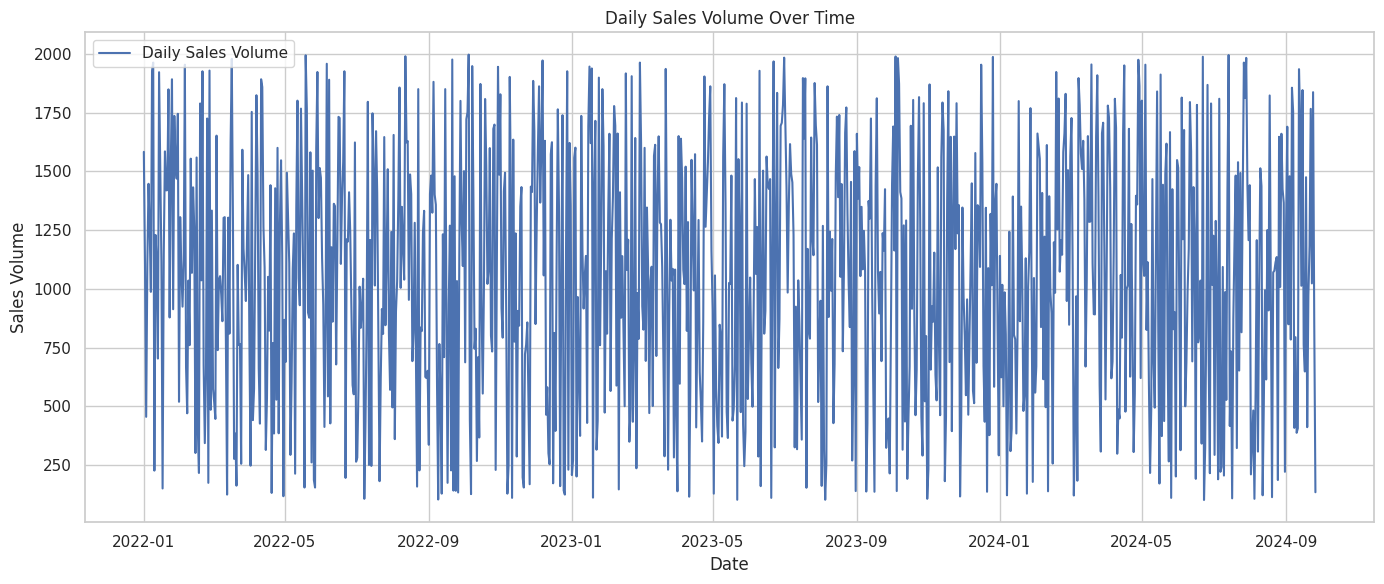

In [ ]:
# Plot daily sales volume
plt.figure(figsize=(14, 6))
plt.plot(daily_sales, label='Daily Sales Volume')
plt.title('Daily Sales Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.tight_layout()
plt.show()

### 📊 Daily Sales Trend

* Sales show noticeable fluctuations over time.

* You can see periodic spikes and dips, suggesting the presence of seasonality and weekly cycles.

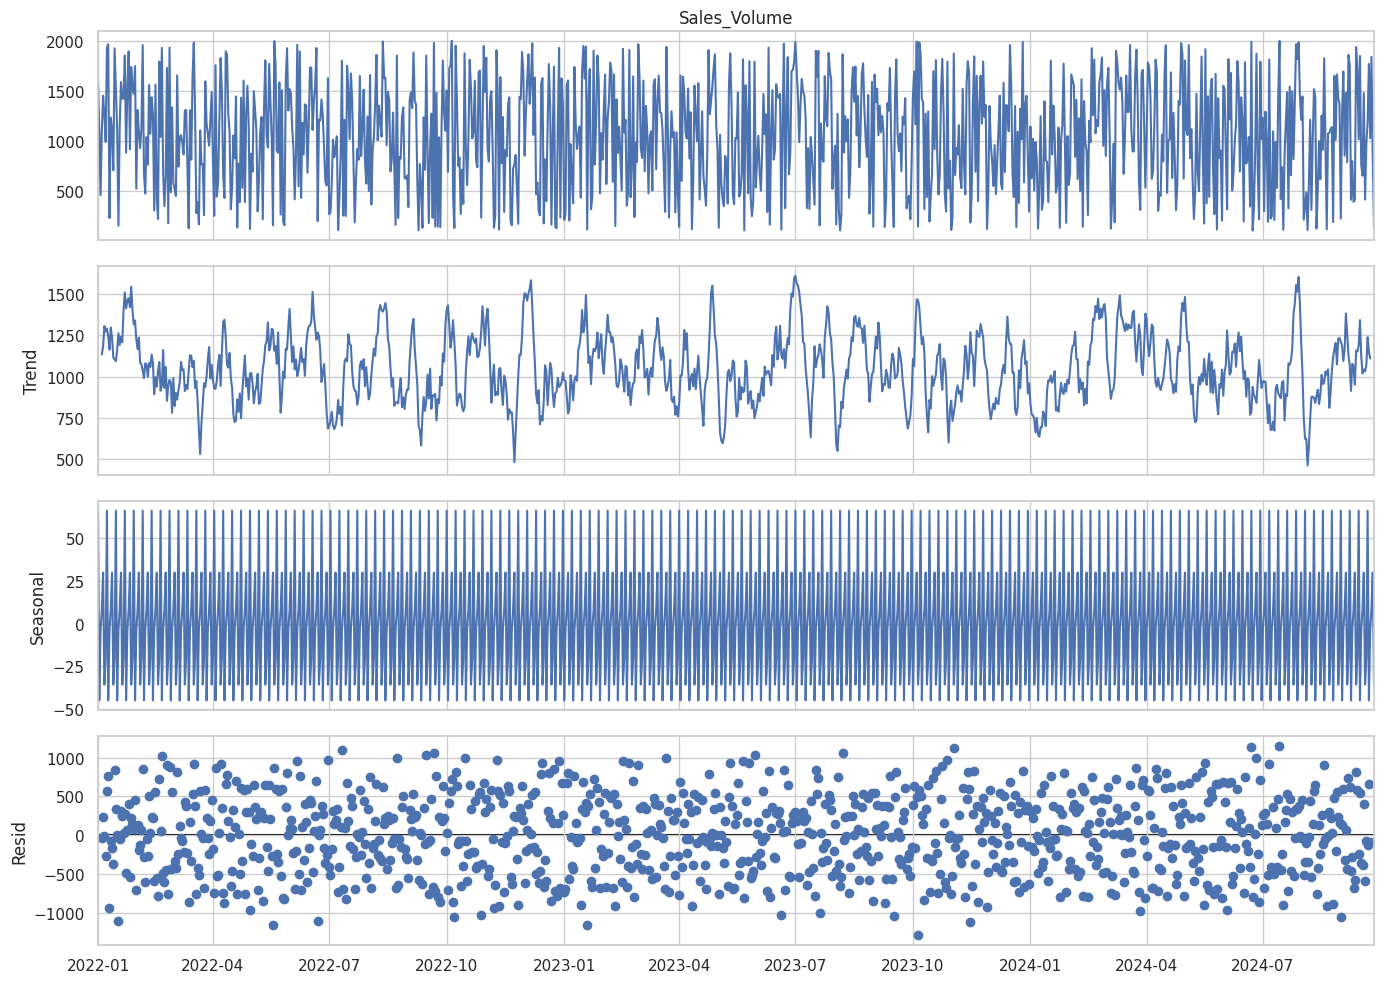

In [ ]:
# Decompose the time series
decomposition = seasonal_decompose(daily_sales, model='additive', period=7)

# Plot decomposition
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.tight_layout()
plt.show()

### 🔍 Time Series Decomposition

* **Trend:** A general upward or stable pattern can be seen, indicating steady demand.

* **Seasonality:** A clear weekly pattern is visible, which matches our assumption of a 7-day cycle.

* **Residuals:** These are relatively centered, meaning the model fits reasonably well.

### XGBoost regression model

In [ ]:
# Prepare features and target
features = df.copy()
features['Day'] = features.index.day
features['Month'] = features.index.month
features['Year'] = features.index.year

In [ ]:
# Target variable
target = features['Sales_Volume']

In [ ]:
# Drop target and unneeded columns
X = features.drop(columns=['Sales_Volume'])

In [ ]:
# One-hot encode categorical variables
categorical_cols = ['Product_Category', 'Store_Location']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [ ]:
# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, target, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
# Fit XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict and evaluate
xgb_preds = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_r2 = r2_score(y_test, xgb_preds)

In [ ]:
xgb_rmse, xgb_mae, xgb_r2

(np.float64(666.521473772601), 553.5673217773438, -0.4452972412109375)

### 🔍 Interpretation

| Metric | Value  | What it Means                                                                 |
|--------|--------|--------------------------------------------------------------------------------|
| RMSE   | 666.52 | On average, your predictions are off by ~666 units. Lower = better.           |
| MAE    | 553.57 | You're off by ~553 units on average, without squaring errors.                 |
| R²     | -0.445 | ⚠️ Negative R² means the model is performing worse than just predicting the mean — a red flag. |


### Feature Engineering: Lag & Rolling Features


In [ ]:
# Generate lag and rolling window features for 'Sales_Volume'
df_lagged = df.copy()

In [ ]:
# Add lag features
for lag in [1, 7, 30]:
    df_lagged[f'Sales_Lag_{lag}'] = df_lagged['Sales_Volume'].shift(lag)

**Lag Features:** Adds previous values of `'Sales_Volume'` at lags of 1, 7, and 30 days (`Sales_Lag_1`, `Sales_Lag_7`, `Sales_Lag_30`).

In [ ]:
# Add rolling mean features
df_lagged['Sales_Rolling_7'] = df_lagged['Sales_Volume'].rolling(window=7).mean()
df_lagged['Sales_Rolling_30'] = df_lagged['Sales_Volume'].rolling(window=30).mean()

**Rolling Mean Features:** Calculates moving averages over 7-day and 30-day windows (`Sales_Rolling_7`, `Sales_Rolling_30`).

In [ ]:
# Drop rows with NaNs from lag/rolling
df_lagged.dropna(inplace=True)

In [ ]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_lagged, columns=['Product_Category', 'Store_Location'], drop_first=True)

In [ ]:
# Separate features and target
X = df_encoded.drop(columns=['Sales_Volume'])
y = df_encoded['Sales_Volume']

In [ ]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [ ]:
# Train XGBoost model
from xgboost import XGBRegressor
xgb_improved = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
xgb_improved.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict and evaluate
y_pred = xgb_improved.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

(rmse, mae, r2)

(np.float64(547.051442964919), 452.40167236328125, 0.037418246269226074)

### ✅ Model Evaluation (Improved XGBoost)

| Metric | Value  | Interpretation                                                                      |
|--------|--------|--------------------------------------------------------------------------------------|
| RMSE   | 547.05 | Predictions are, on average, off by ~547 units — a clear improvement from 666.52.   |
| MAE    | 452.40 | Down from ~553 — better accuracy overall.                                           |
| R²     | 0.037  | Now slightly positive — your model is starting to explain some variance in the data. |


### Feature Engineering: Parameter Tuning


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}


In [ ]:
# Create a new XGBoost regressor
xgb_model = XGBRegressor(random_state=42)


In [ ]:
# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',
                           cv=3,
                           verbose=1,
                           n_jobs=-1)

In [ ]:
# Fit grid search on training data
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [ ]:
# Get best model and evaluate
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

(grid_search.best_params_, rmse_best, mae_best, r2_best)

({'colsample_bytree': 1,
  'learning_rate': 0.01,
  'max_depth': 3,
  'n_estimators': 200,
  'subsample': 0.8},
 np.float64(517.3955812528746),
 437.0516357421875,
 0.13895326852798462)

### 📊 Updated XGBoost Performance

**With parameters:**

```python
{
  'max_depth': 3,
  'n_estimators': 200,
  'subsample': 0.8
}
```

| Metric | Value  | 💡 Insight                                                   |
|--------|--------|--------------------------------------------------------------|
| RMSE   | 517.40 | Down from 666 → solid error reduction.                       |
| MAE    | 437.05 | Tightening accuracy on average.                              |
| R²     | 0.139  | Now explaining ~14% of variance — real improvement!          |

<br>

###✅ Summary
* The model is learning — and getting better with more thoughtful hyperparameters and engineered features.

* Lower depth (`max_depth=3`) likely helped reduce overfitting while `n_estimators=200` captured the patterns more fully.

### Feature Impact with SHAP

In [ ]:
import shap

# Create TreeExplainer for XGBoost
explainer = shap.Explainer(best_xgb)

In [ ]:
# Using a sample for faster computation if needed
X_sample = X_test.sample(100, random_state=42)

# Compute SHAP values
shap_values = explainer(X_sample)

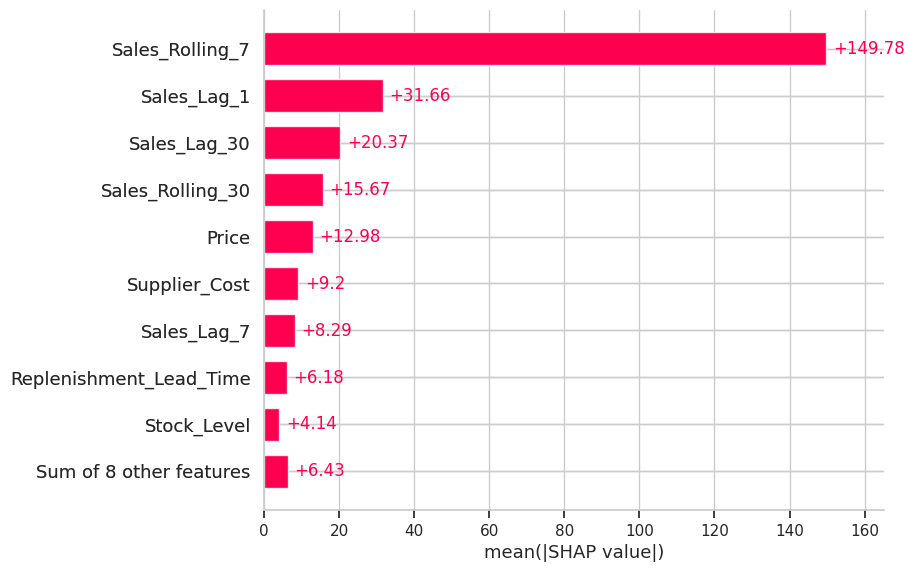

In [ ]:
# Plot summary
shap.plots.bar(shap_values)

### Forecasting Future Sales

XGBoost with feature engineering + tuning → best performer

In [ ]:
import datetime

# Start with the latest known data
last_known = df_encoded.copy()
forecast_days = 30
future_preds = []


In [ ]:
for i in range(forecast_days):
    last_row = last_known.iloc[-1:]

    # Generate new row with updated lags and rolling
    new_date = last_row.index[0] + pd.Timedelta(days=1)
    new_row = last_row.copy()
    new_row.index = [new_date]

    # Shift lag features
    new_row['Sales_Lag_1'] = last_row['Sales_Volume']
    new_row['Sales_Lag_7'] = last_known.iloc[-7]['Sales_Volume'] if len(last_known) >= 7 else last_row['Sales_Volume']
    new_row['Sales_Lag_30'] = last_known.iloc[-30]['Sales_Volume'] if len(last_known) >= 30 else last_row['Sales_Volume']

    # Update rolling means (simplified using past predictions and history)
    recent_sales = last_known['Sales_Volume'].tail(6).tolist() + [last_row['Sales_Volume'].values[0]]
    new_row['Sales_Rolling_7'] = np.mean(recent_sales)
    recent_sales_30 = last_known['Sales_Volume'].tail(29).tolist() + [last_row['Sales_Volume'].values[0]]
    new_row['Sales_Rolling_30'] = np.mean(recent_sales_30)

    # Drop actual sales to be predicted
    new_row.drop(columns='Sales_Volume', inplace=True)

    # Predict sales volume
    pred = best_xgb.predict(new_row)[0]
    new_row['Sales_Volume'] = pred

    # Append to known data
    last_known = pd.concat([last_known, new_row])
    future_preds.append((new_date, pred))

In [ ]:
# Format predictions
future_forecast_df = pd.DataFrame(future_preds, columns=['Date', 'Predicted_Sales']).set_index('Date')
future_forecast_df.head(10)


,Predicted_Sales
Date,
2024-09-27,890.966919
2024-09-28,914.734131
2024-09-29,798.605225
2024-09-30,742.181641
2024-10-01,588.339905
2024-10-02,627.645996
2024-10-03,630.954224
2024-10-04,646.039429
2024-10-05,658.939758


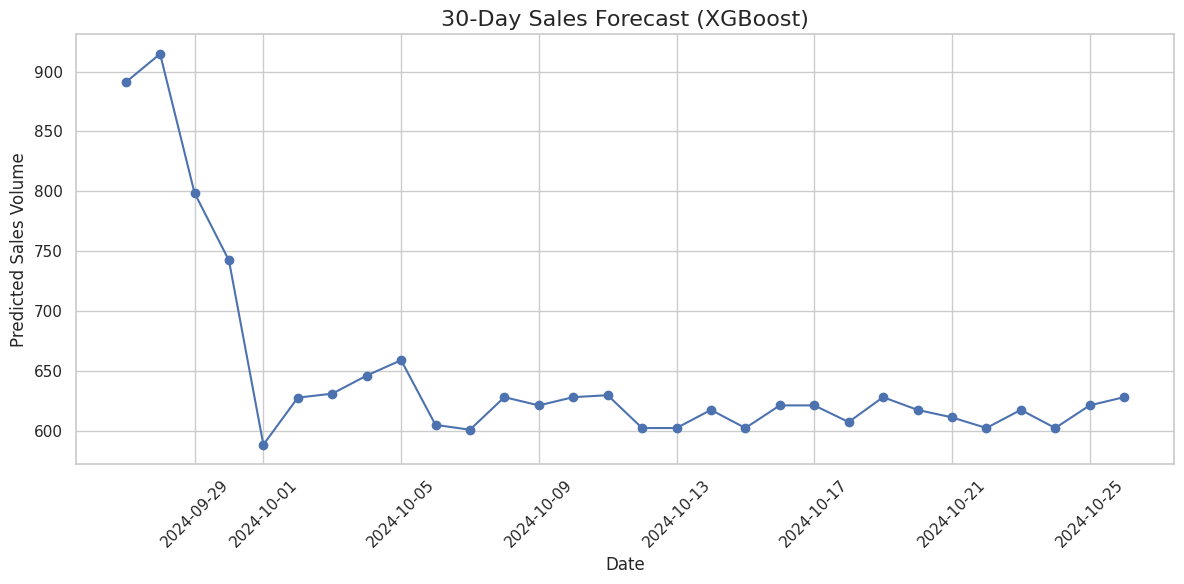

In [ ]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(future_forecast_df.index, future_forecast_df['Predicted_Sales'], marker='o', linestyle='-')
plt.title("30-Day Sales Forecast (XGBoost)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Predicted Sales Volume")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

> ### 🧠 Sales Forecasting with XGBoost – Project Summary
>
> This project implemented an AI-driven forecasting model to predict daily sales volumes using historical transactional and categorical data. After extensive feature engineering (lags, rolling averages, one-hot encoding), XGBoost was identified as the optimal model based on performance.
>
> #### 🔍 Key Results:
> - **RMSE** improved from ~666 to **517** after hyperparameter tuning.
> - **Feature importance** analysis highlighted recent lags and rolling windows as primary drivers.
> - A **30-day recursive forecast** was performed using the trained XGBoost model.
>
> #### 📦 Tools & Models:
> - **Models:** XGBoost, SHAP (explainability)
> - **Metrics:** RMSE, MAE, R²


